In [76]:
from pathlib import Path
import torch
import pandas as pd
import stat
import numbers
import pydicom
import numpy as np
from tqdm import tqdm
from collections import Counter
import re
import os
from PIL import Image
from matplotlib import pyplot as plt

In [4]:
Path().resolve()

PosixPath('/home/buehlern/Documents/Masterarbeit/notebooks')

In [5]:
df_loc = Path('../data/clean_df_slim_frac.pkl')
df = pd.read_pickle(df_loc)

In [ ]:
df = df.loc[:, ~df.columns.duplicated()].copy()
df

In [39]:
df[['x', 'y']] = df['pixelarr_shape'].tolist()
df[['pixelarr_shape', 'x', 'y']]

,pixelarr_shape,x,y
0,"(2947, 1140)",2947,1140
1,"(3001, 2220)",3001,2220
2,"(2903, 1267)",2903,1267
3,"(2622, 1132)",2622,1132
4,"(2834, 1261)",2834,1261
...,...,...,...
639872,"(3056, 1250)",3056,1250
639873,"(1654, 960)",1654,960
639874,"(1485, 831)",1485,831
639875,"(1791, 880)",1791,880


# Finding Padding Cutoff Points

Text(0, 0.5, 'Frequency')

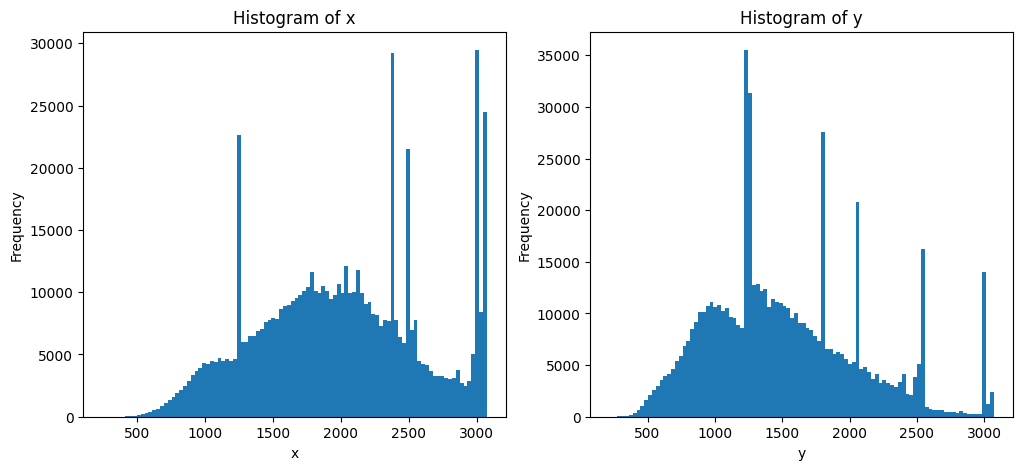

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['x'], bins=100)
plt.title('Histogram of x')
plt.xlabel('x')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['y'], bins=100)
plt.title('Histogram of y')
plt.xlabel('y')
plt.ylabel('Frequency')

## Independent Width / Height

In [42]:
x_bins = np.percentile(df['x'], [0, 25, 50, 75, 100])
y_bins = np.percentile(df['y'], [0, 25, 50, 75, 100])

print("x cutoff points:", x_bins)
print("y cutoff points:", y_bins)

x cutoff points: [ 246. 1543. 2002. 2438. 3072.]
y cutoff points: [ 219. 1117. 1417. 1852. 3071.]


Text(0, 0.5, 'Frequency')

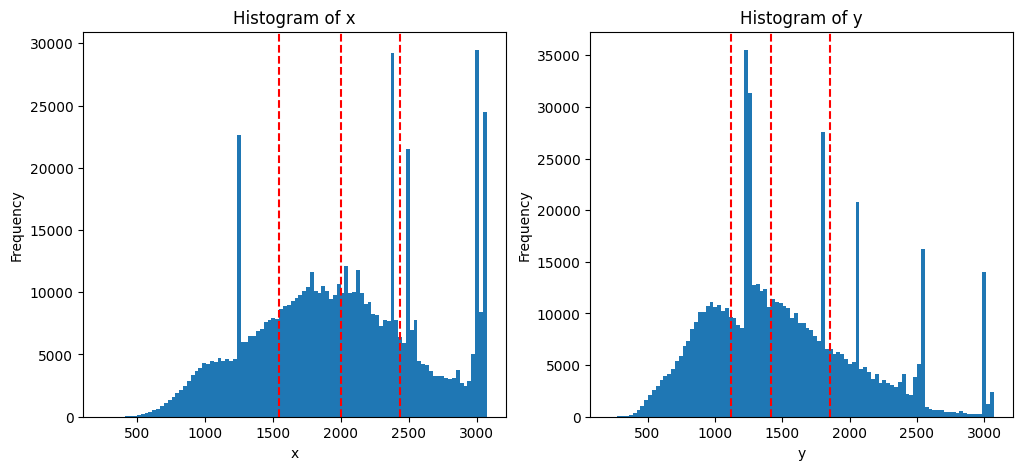

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['x'], bins=100)
plt.axvline(x_bins[1], color='r', linestyle='--', label='25th percentile')
plt.axvline(x_bins[2], color='r', linestyle='--', label='50th percentile')
plt.axvline(x_bins[3], color='r', linestyle='--', label='75th percentile')
plt.title('Histogram of x')
plt.xlabel('x')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['y'], bins=100)
plt.axvline(y_bins[1], color='r', linestyle='--', label='25th percentile')
plt.axvline(y_bins[2], color='r', linestyle='--', label='50th percentile')
plt.axvline(y_bins[3], color='r', linestyle='--', label='75th percentile')
plt.title('Histogram of y')
plt.xlabel('y')
plt.ylabel('Frequency')

## Total Tokens

In [45]:
def calculate_tokens(width, height, patch_size):
    padded_width = np.ceil(width / patch_size) * patch_size
    padded_height = np.ceil(height / patch_size) * patch_size
    num_tokens = (padded_width * padded_height) / (patch_size ** 2)
    return num_tokens

In [46]:
df['num_tokens_ps8'] = df.apply(lambda row: calculate_tokens(row['x'], row['y'], 8), axis=1)
df['num_tokens_ps16'] = df.apply(lambda row: calculate_tokens(row['x'], row['y'], 16), axis=1)
df['num_tokens_ps32'] = df.apply(lambda row: calculate_tokens(row['x'], row['y'], 32), axis=1)
df['num_tokens_ps48'] = df.apply(lambda row: calculate_tokens(row['x'], row['y'], 48), axis=1)

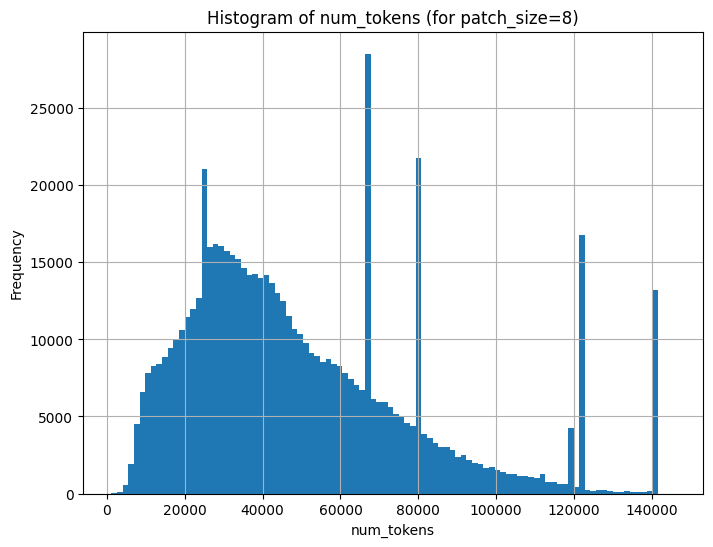

In [48]:
plt.figure(figsize=(8, 6))
plt.hist(df['num_tokens_ps8'], bins=100)
plt.title('Histogram of num_tokens (for patch_size=8)')
plt.xlabel('num_tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

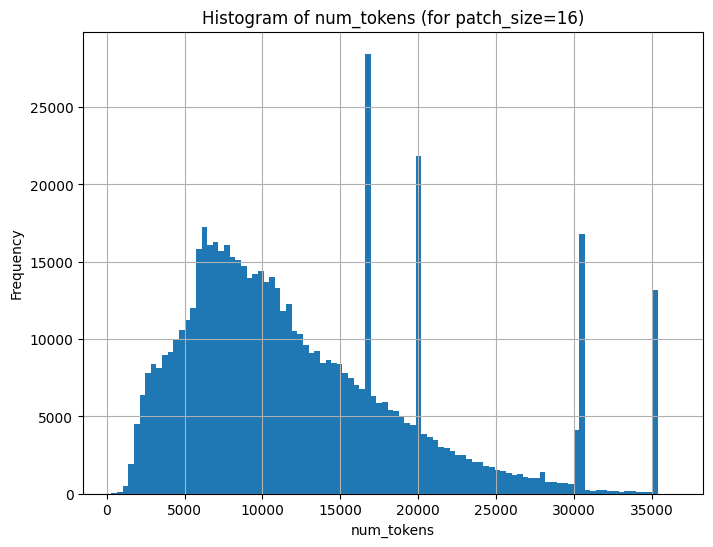

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(df['num_tokens_ps16'], bins=100)
plt.title('Histogram of num_tokens (for patch_size=16)')
plt.xlabel('num_tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

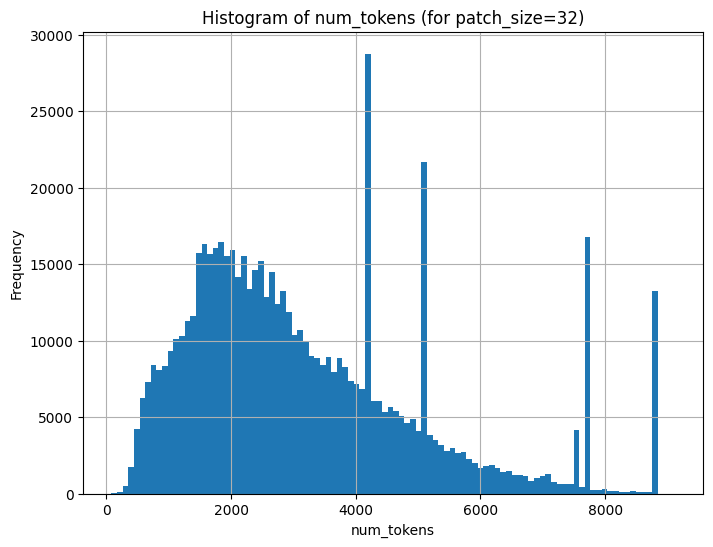

In [50]:
plt.figure(figsize=(8, 6))
plt.hist(df['num_tokens_ps32'], bins=100)
plt.title('Histogram of num_tokens (for patch_size=32)')
plt.xlabel('num_tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

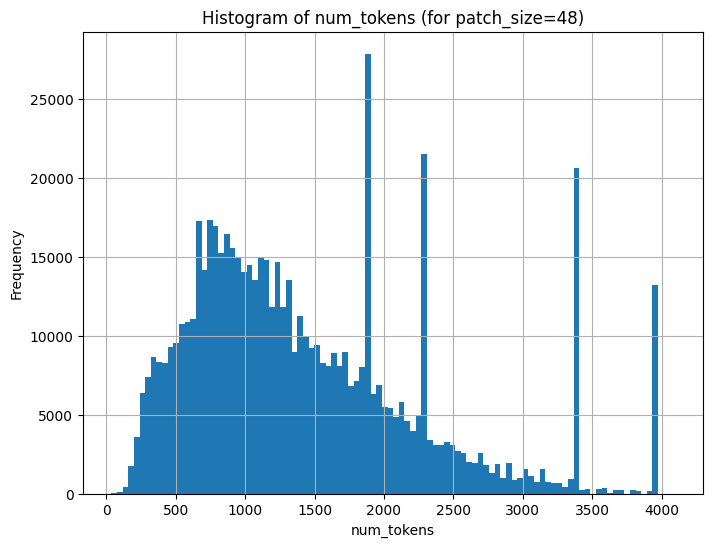

In [51]:
plt.figure(figsize=(8, 6))
plt.hist(df['num_tokens_ps48'], bins=100)
plt.title('Histogram of num_tokens (for patch_size=48)')
plt.xlabel('num_tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Checking Different DataLoader types

In [1]:
import sys
sys.path.insert(1, '/home/buehlern/Documents/Masterarbeit/models')
from src.data.mri_datamodule import MRIDataModule

/home/buehlern/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pad_to_bins = [1152, 1536, 1920, 2304, 2688, 3072]

In [3]:
mri_datamodule = MRIDataModule(batch_size = 8, image_size = 3072, square = True, cache = False, fix_inverted = True)

initializing MRIDatasetBase ...
reading /home/buehlern/Documents/Masterarbeit/data/clean_df_slim_frac.pkl file ...
PATH /home/buehlern/Documents/Masterarbeit/data/BodyPartExamined_mappings_mergemore.json
/home/buehlern/Documents/Masterarbeit/data/cache-full/df_labelcomparison.pkl does not exit --> no items excluded by it
MRIDatasetBase(len=639877) initialized

initializing MRIDataset(mode=train) ...
MRIDataset(mode=train, len=516402) initialized

initializing MRIDataset(mode=val) ...
MRIDataset(mode=val, len=27518) initialized

initializing MRIDataset(mode=test) ...
WARN: including test data
MRIDataset(mode=test, len=95957) initialized


In [4]:
len(mri_datamodule.data_train)

516402

In [5]:
%%time
len(mri_datamodule.train_dataloader())

DataLoader length 64551
CPU times: user 345 μs, sys: 31 μs, total: 376 μs
Wall time: 383 μs


64551

In [6]:
mri_datamodule_pad_to_multiple = MRIDataModule(batch_size = 8, pad_to_multiple_of = 8, square = False, cache = False, fix_inverted = True)

initializing MRIDatasetBase ...
reading /home/buehlern/Documents/Masterarbeit/data/clean_df_slim_frac.pkl file ...
PATH /home/buehlern/Documents/Masterarbeit/data/BodyPartExamined_mappings_mergemore.json
/home/buehlern/Documents/Masterarbeit/data/cache-full/df_labelcomparison.pkl does not exit --> no items excluded by it
MRIDatasetBase(len=639877) initialized

initializing MRIDataset(mode=train) ...
MRIDataset(mode=train, len=516402) initialized

initializing MRIDataset(mode=val) ...
MRIDataset(mode=val, len=27518) initialized

initializing MRIDataset(mode=test) ...
WARN: including test data
MRIDataset(mode=test, len=95957) initialized


In [7]:
len(mri_datamodule_pad_to_multiple.data_train)

516402

In [8]:
%%time
len(mri_datamodule_pad_to_multiple.train_dataloader())

DataLoader length 64551
CPU times: user 106 μs, sys: 9 μs, total: 115 μs
Wall time: 119 μs


64551

In [3]:
mri_datamodule_strict_binning = MRIDataModule(batch_size = 8, batch_binning = 'strict', cache = False, fix_inverted = True)

initializing MRIDatasetBase ...
reading /home/buehlern/Documents/Masterarbeit/data/clean_df_slim_frac.pkl file ...
PATH /home/buehlern/Documents/Masterarbeit/data/BodyPartExamined_mappings_mergemore.json
/home/buehlern/Documents/Masterarbeit/data/cache-full/df_labelcomparison.pkl does not exit --> no items excluded by it
MRIDatasetBase(len=639877) initialized

initializing MRIDataset(mode=train) ...
MRIDataset(mode=train, len=516402) initialized

initializing MRIDataset(mode=val) ...
MRIDataset(mode=val, len=27518) initialized

initializing MRIDataset(mode=test) ...
WARN: including test data
MRIDataset(mode=test, len=95957) initialized


In [4]:
len(mri_datamodule_strict_binning.data_train)

516402

In [5]:
%%time
len(mri_datamodule_strict_binning.train_dataloader())

DataLoader length 14834
CPU times: user 17.5 s, sys: 44.2 ms, total: 17.5 s
Wall time: 17.5 s


14834

In [3]:
mri_datamodule_smart_binning = MRIDataModule(batch_size = 8, batch_binning = 'smart', batch_bins = pad_to_bins, cache = False, fix_inverted = True)

initializing MRIDatasetBase ...
reading /home/buehlern/Documents/Masterarbeit/data/clean_df_slim_frac.pkl file ...
PATH /home/buehlern/Documents/Masterarbeit/data/BodyPartExamined_mappings_mergemore.json
/home/buehlern/Documents/Masterarbeit/data/cache-full/df_labelcomparison.pkl does not exit --> no items excluded by it
MRIDatasetBase(len=639877) initialized

initializing MRIDataset(mode=train) ...
MRIDataset(mode=train, len=516402) initialized

initializing MRIDataset(mode=val) ...
MRIDataset(mode=val, len=27518) initialized

initializing MRIDataset(mode=test) ...
WARN: including test data
MRIDataset(mode=test, len=95957) initialized


In [4]:
len(mri_datamodule_smart_binning.data_train)

516402

In [5]:
%%time
len(mri_datamodule_smart_binning.train_dataloader())

DataLoader length 64535
CPU times: user 17.8 s, sys: 28.6 ms, total: 17.8 s
Wall time: 17.8 s


64535

Using `img_size_map` decreases loading time from 12h+ to 17.8s. 

# Debugging Smart Binning

In [1]:
import sys
sys.path.insert(1, '/home/buehlern/Documents/Masterarbeit/models')
from src.data.mri_datamodule import MRIDataModule

/home/buehlern/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pad_to_bins = [1152, 1536, 1920, 2304, 2688, 3072]

In [3]:
mri_datamodule_smart_binning = MRIDataModule(batch_size = 8, batch_binning = 'smart', batch_bins = pad_to_bins, cache = False, fix_inverted = True)

initializing MRIDatasetBase ...
reading /home/buehlern/Documents/Masterarbeit/data/clean_df_slim_frac.pkl file ...
PATH /home/buehlern/Documents/Masterarbeit/data/BodyPartExamined_mappings_mergemore.json
/home/buehlern/Documents/Masterarbeit/data/cache-full/df_labelcomparison.pkl does not exit --> no items excluded by it
MRIDatasetBase(len=639877) initialized

initializing MRIDataset(mode=train) ...
MRIDataset(mode=train, len=516402) initialized

initializing MRIDataset(mode=val) ...
MRIDataset(mode=val, len=27518) initialized

initializing MRIDataset(mode=test) ...
WARN: including test data
MRIDataset(mode=test, len=95957) initialized


In [4]:
dl = mri_datamodule_smart_binning.train_dataloader()

DataLoader length 64535


In [10]:
dl_it = iter(dl)
for i in range(10):
    batch = next(dl_it)
    print(batch[0].shape)

torch.Size([8, 1, 2688, 1920])
torch.Size([8, 1, 1536, 1920])
torch.Size([8, 1, 2304, 1536])
torch.Size([8, 1, 1536, 1152])
torch.Size([8, 1, 2304, 1536])
torch.Size([8, 1, 3072, 2688])
torch.Size([8, 1, 2304, 1536])
torch.Size([8, 1, 3072, 1920])
torch.Size([8, 1, 3072, 1536])
torch.Size([8, 1, 2304, 1536])


In [73]:
def show_image(image, title=''):
    # image is [H, W, 1]
    #print(image.shape)
    assert image.shape[2] == 1
    plt.imshow(image, cmap=plt.cm.bone)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

In [ ]:
# Check some random items
for bin in dl.batch_sampler.size_to_indices:
    print("Checking bin:", bin)
    # Pick the first item from this bin
    item = dl.batch_sampler.size_to_indices[bin][0]
    # Check it
    print("  Checking item", item)
    bin_size = bin
    original_size =  dl.batch_sampler.data_source.df.iloc[item]['pixelarr_shape'][0]
    padded_size = dl.batch_sampler.data_source[item][0].shape
    print("    Bin size:", bin_size)
    print("    Original size:", original_size)
    print("    Padded size:", padded_size)
    # Visualize it
    pixel_values = dl.batch_sampler.data_source[item][0]
    x = torch.einsum('chw->hwc', pixel_values)
    show_image(x, "Padded image " + str(bin))
    plt.show()

In [ ]:
bin = (3072, 1152)
item = dl.batch_sampler.size_to_indices[bin][0]
pixel_values = dl.batch_sampler.data_source[item][0]
x = torch.einsum('chw->hwc', pixel_values)
show_image(x, "Padded image " + str(bin))
plt.show()

# Checking distribution across bins for Smart Binning Strategy

In [106]:
from collections import defaultdict

In [150]:
scans_per_tokens = defaultdict(int)
scans_per_size = defaultdict(int)
for bin in dl.batch_sampler.size_to_indices:
    bin_size = len(dl.batch_sampler.size_to_indices[bin])
    patch_size = 48
    tokens = bin[0] * bin[1] // (patch_size**2)
    scans_per_tokens[tokens] = scans_per_tokens[tokens]+bin_size
    scans_per_size[str(bin)] = scans_per_size[str(bin)]+bin_size
    print("Bin", bin, "contains", bin_size, "items")

Bin (3072, 1536) contains 14469 items
Bin (2688, 1152) contains 2250 items
Bin (3072, 2688) contains 20730 items
Bin (3072, 1920) contains 17979 items
Bin (2688, 1920) contains 40207 items
Bin (2688, 2304) contains 28949 items
Bin (3072, 2304) contains 11018 items
Bin (1920, 1152) contains 44104 items
Bin (3072, 1152) contains 1936 items
Bin (3072, 3072) contains 12045 items
Bin (1920, 2304) contains 2358 items
Bin (2688, 1536) contains 17491 items
Bin (2304, 3072) contains 584 items
Bin (2304, 1920) contains 29707 items
Bin (2304, 1536) contains 49033 items
Bin (1920, 3072) contains 453 items
Bin (2688, 2688) contains 4248 items
Bin (2688, 3072) contains 3492 items
Bin (2304, 1152) contains 17788 items
Bin (1920, 1536) contains 48276 items
Bin (1536, 3072) contains 702 items
Bin (1536, 1536) contains 23835 items
Bin (2304, 2304) contains 6679 items
Bin (1920, 2688) contains 2733 items
Bin (1920, 1920) contains 9699 items
Bin (1536, 1920) contains 3738 items
Bin (2304, 2688) contains 2

In [151]:
print("Bin count:", len(dl.batch_sampler.size_to_indices))

Bin count: 36


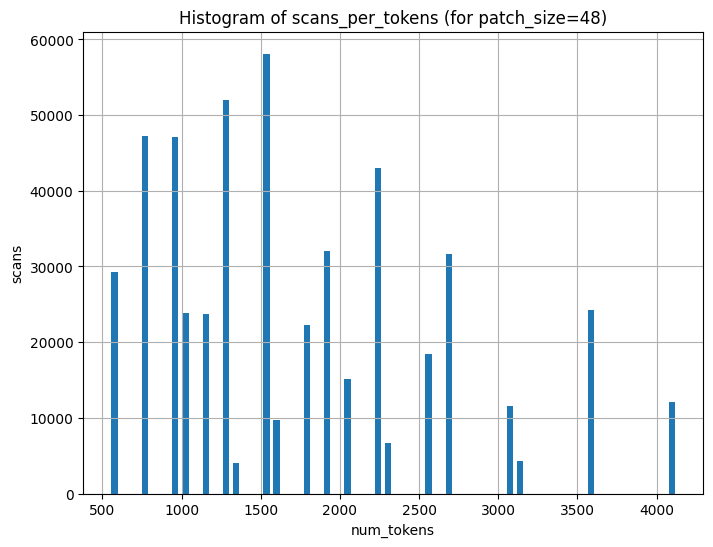

In [152]:
plt.figure(figsize=(8, 6))
plt.bar(scans_per_tokens.keys(), scans_per_tokens.values(), 40)
plt.title('Histogram of scans_per_tokens (for patch_size=48)')
plt.xlabel('num_tokens')
plt.ylabel('scans')
plt.grid(True)
plt.show()

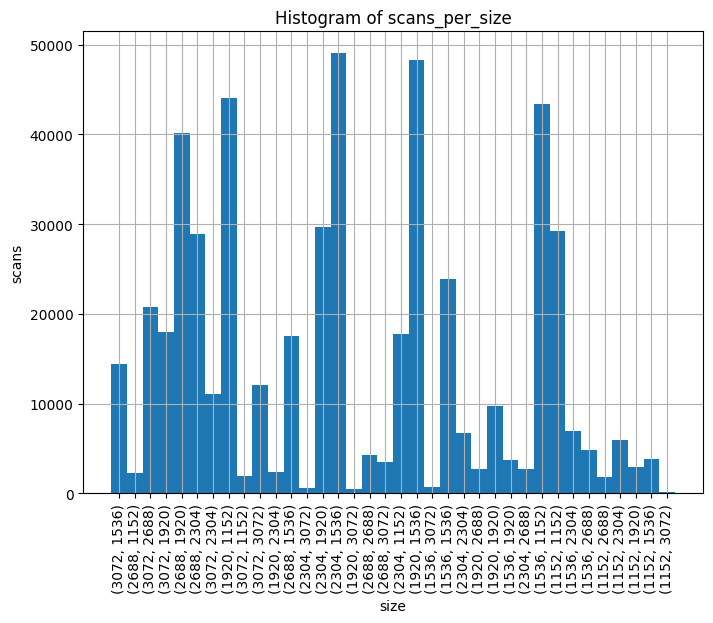

In [165]:
plt.figure(figsize=(8, 6))
plt.bar(scans_per_size.keys(), scans_per_size.values(), 1)
plt.title('Histogram of scans_per_size')
plt.xticks(rotation=90)
plt.xlabel('size')
plt.ylabel('scans')
plt.grid(True)
plt.show()

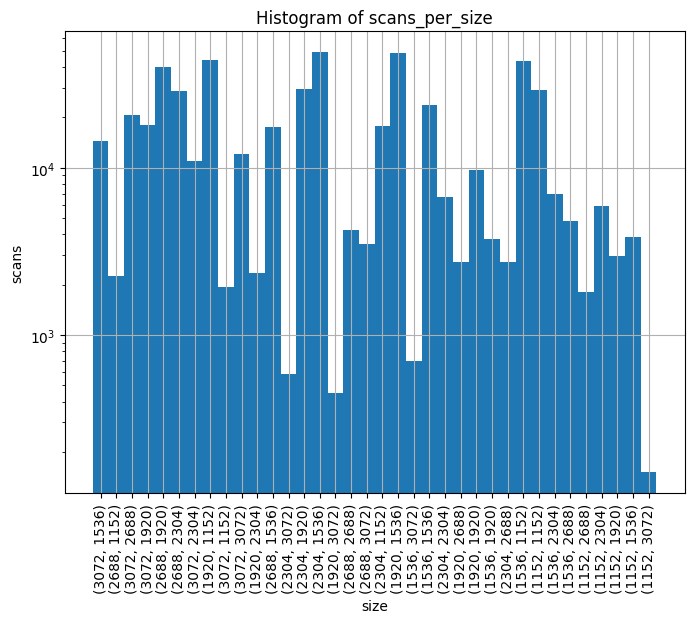

In [167]:
plt.figure(figsize=(8, 6))
plt.bar(scans_per_size.keys(), scans_per_size.values(), 1)
plt.title('Histogram of scans_per_size')
plt.xticks(rotation=90)
plt.xlabel('size')
plt.yscale('log')
plt.ylabel('scans')
plt.grid(True)
plt.show()